# Basic model for our classification task

In this notebook I want to check the idea of predicting Go game winner with some CNN models. 
Also below we have some dummy EDA for our data.

```/train/``` - contain images which was converted from [this](https://github.com/featurecat/go-dataset/tree/master/18k) sgf-files

```/test/``` - contain images which was converted from [this](https://github.com/featurecat/go-dataset/tree/master/17k) sgf-files

GPU that was used for training model:

In [1]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free --format=csv

name, memory.total [MiB], memory.free [MiB]
Tesla P100-PCIE-16GB, 16280 MiB, 16280 MiB


This notebook was provided with Kaggle free quota for GPU. I also tried to train it on the Google Colab, but it provide only Tesla K80 with 12 GB.

## Libraries 

In [2]:
from collections import Counter 
from torch import nn
from torchvision import transforms, datasets, utils, models
from tqdm import tqdm
import torch

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 

I upload train and test dataset to the Google Drive. So below we download it and unzip.

In [3]:
!pip install gdown > /dev/null
# links to zip files with datasets on Google Drive
# train.zip
!gdown --id 1jycMnCmBH8v0BLQmXYfyJRiAg2lVFPjx
# test.zip
!gdown --id 1a0KpcA8SwRpIktITycDuYG2PfmWVBJBE

Downloading...
From: https://drive.google.com/uc?id=1jycMnCmBH8v0BLQmXYfyJRiAg2lVFPjx
To: /kaggle/working/train.zip
100%|█████████████████████████████████████████| 808M/808M [00:05<00:00, 138MB/s]
Downloading...
From: https://drive.google.com/uc?id=1a0KpcA8SwRpIktITycDuYG2PfmWVBJBE
To: /kaggle/working/test.zip
100%|█████████████████████████████████████████| 184M/184M [00:01<00:00, 167MB/s]


In [4]:
!unzip train.zip > /dev/null
!unzip test.zip > /dev/null

## Set some parameters and basic constants

In [5]:
TRAIN_DIR = "train"
TEST_DIR = "test"
SEED = 42
BATCH_SIZE = 32
EPOCHS = 30

np.random.seed(SEED)
torch.manual_seed(SEED)

plt.rcParams["figure.figsize"] = [15, 8]
plt.rcParams["font.size"] = 20

## Create dataloaders 
Also in future we can transform RGB images to Grayscale

In [6]:
data_transform = transforms.Compose([
        transforms.ToTensor()
    ])
train_dataset = datasets.ImageFolder(root=TRAIN_DIR,
                                           transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=BATCH_SIZE, shuffle=True)
test_dataset = datasets.ImageFolder(root=TEST_DIR,
                                           transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE, shuffle=True)

In [7]:
print(f"There are {len(train_dataset)} images in train dataset")
print(f"There are {len(test_dataset)} images in test dataset")

There are 6785 images in train dataset
There are 1440 images in test dataset


In [8]:
def distribution_plot(loader: torch.utils.data.dataloader.DataLoader, dataset_mode:str)->None:
    
    index = 0 if dataset_mode == "train" else 1
    
    graph = sns.barplot(data=pd.DataFrame(data = np.array([[*Counter(loader.dataset.targets).values()]]), 
                                      columns=train_loader.dataset.classes), ax = ax[index])
    
    ax[index].set_title(f"Distribution of classes in {dataset_mode.title()} Dataset")
    ax[index].set_ylabel("Count")
    for p in graph.patches:
        graph.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()),
                            ha='center', va='center', fontsize=20, xytext=(0, 9),
                            textcoords='offset points',fontweight='light', alpha=0.95) 

## Dataset little analysis 

We have imbalanced dataset (so we need to delete Draw class in future or add more images with Draw situations).

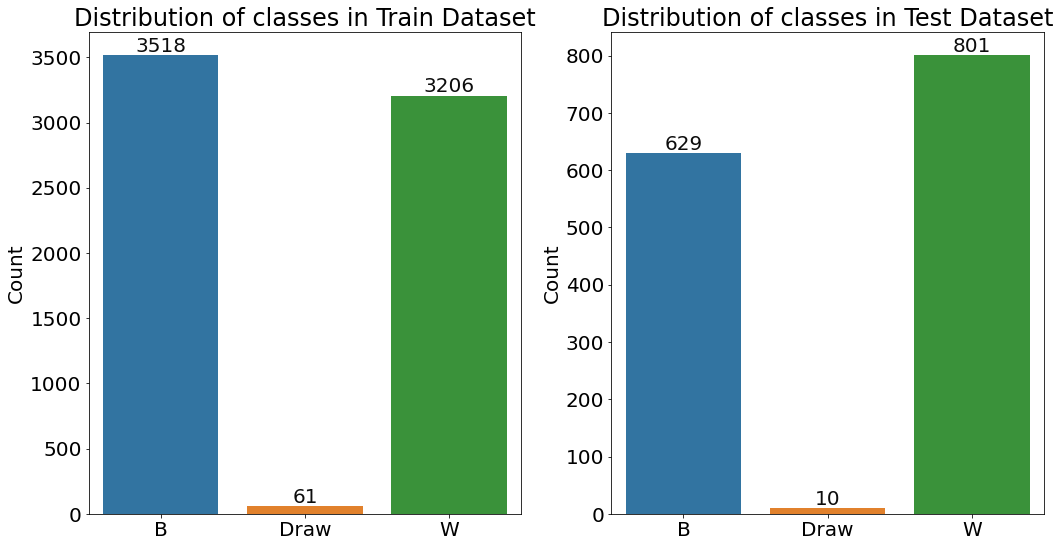

In [9]:
fig, ax = plt.subplots(1,2)
distribution_plot(train_loader, "train")
distribution_plot(test_loader, "test")
fig.tight_layout()
fig.show()

In [10]:
img, label = next(iter(train_loader))

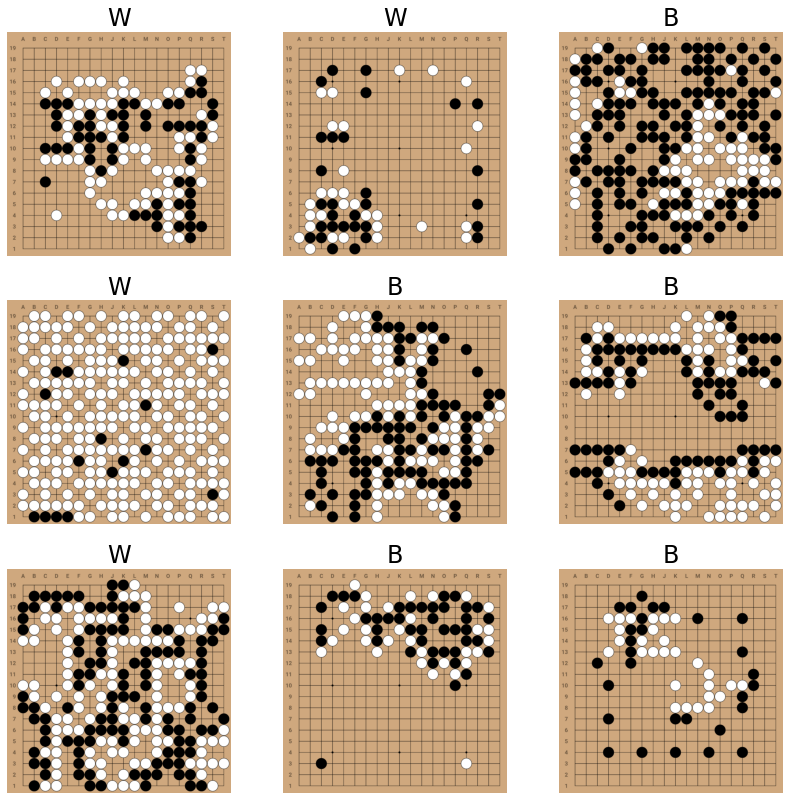

In [11]:
figure = plt.figure(figsize=(14, 14))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(train_dataset.classes[label])
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
    
plt.show()

## Model

As basic model I use ResNet18, because ResNet provide good results and 18-layers it's minimum model from residual networks family in pytorch.

In [15]:
model_resnet = models.resnet18(pretrained=False)
output_features = len(train_dataset.classes)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, output_features)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  
print(f"Availiable device for training: <{device}>")
model_resnet = model_resnet.to(device)
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
loss = nn.CrossEntropyLoss()  

train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(1, EPOCHS + 1):
    with tqdm(train_loader, unit="batch") as tepoch:
        train_loss = 0
        test_loss = 0
        train_acc = 0
        test_acc = 0
        model_resnet.train()
        for (X, y) in tepoch:
            tepoch.set_description(f"Epoch [{epoch}/{EPOCHS}] | LR [{optimizer.param_groups[0]['lr']}] | Train set")
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model_resnet(X)
            l = loss(y_hat, y)
            l.backward()
            train_loss += l.item()
            train_acc += torch.sum(y_hat.max(dim=1)[1] == y).item()
            optimizer.step()
            tepoch.set_postfix({"Train Loss": train_loss / len(train_loader), 
                                "Train Accuracy":  100. * train_acc / len(train_dataset)})
    train_losses.append(train_loss/len(train_loader))
    train_accuracies.append(100. * train_acc / len(train_dataset))
        
    model_resnet.eval()
    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as tepoch:

            for (X, y) in tepoch:
                tepoch.set_description(" " * 27 + "Test set ")
                X, y = X.to(device), y.to(device)

                y_hat = model_resnet(X)
                l = loss(y_hat, y)

                test_acc += torch.sum(y_hat.max(dim=1)[1] == y).item()
                test_loss += l.item()
                tepoch.set_postfix({"Test Loss": test_loss / len(test_loader), 
                                "Test Accuracy": 100. * test_acc / len(test_dataset)})
    test_losses.append(test_loss/len(test_loader))
    test_accuracies.append(100. * test_acc / len(test_dataset))
    scheduler.step(test_loss/len(test_loader))
    torch.save(model_resnet.state_dict(), "weights.pth")

Availiable device for training: <cuda:0>


Epoch [1/30] | LR [0.01] | Train set: 100%|██████████| 213/213 [04:10<00:00,  1.18s/batch, Train Loss=0.665, Train Accuracy=69.2] 
                           Test set : 100%|██████████| 45/45 [00:35<00:00,  1.27batch/s, Test Loss=0.721, Test Accuracy=66.1]
Epoch [2/30] | LR [0.01] | Train set: 100%|██████████| 213/213 [04:10<00:00,  1.18s/batch, Train Loss=0.558, Train Accuracy=76.3] 
                           Test set : 100%|██████████| 45/45 [00:35<00:00,  1.28batch/s, Test Loss=1.01, Test Accuracy=63.7] 
Epoch [3/30] | LR [0.01] | Train set: 100%|██████████| 213/213 [04:10<00:00,  1.18s/batch, Train Loss=0.545, Train Accuracy=76.7] 
                           Test set : 100%|██████████| 45/45 [00:35<00:00,  1.27batch/s, Test Loss=0.504, Test Accuracy=79.4]
Epoch [4/30] | LR [0.01] | Train set: 100%|██████████| 213/213 [04:10<00:00,  1.18s/batch, Train Loss=0.547, Train Accuracy=75.8] 
                           Test set : 100%|██████████| 45/45 [00:35<00:00,  1.27batch/s, Test Loss

In [16]:
def metric_plot(train_metric: list, test_metric: list, metric_name: str) -> None:
    plt.plot(train_metric,'-o')
    plt.plot(test_metric,'-o')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend([f'Train {metric_name}',f'Test {metric_name}'])
    plt.title(f'Model {metric_name}')
    plt.show()

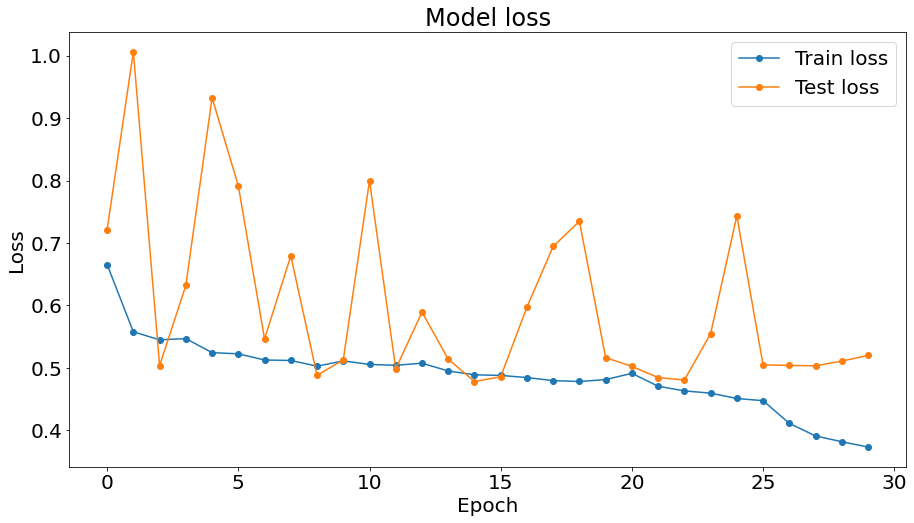

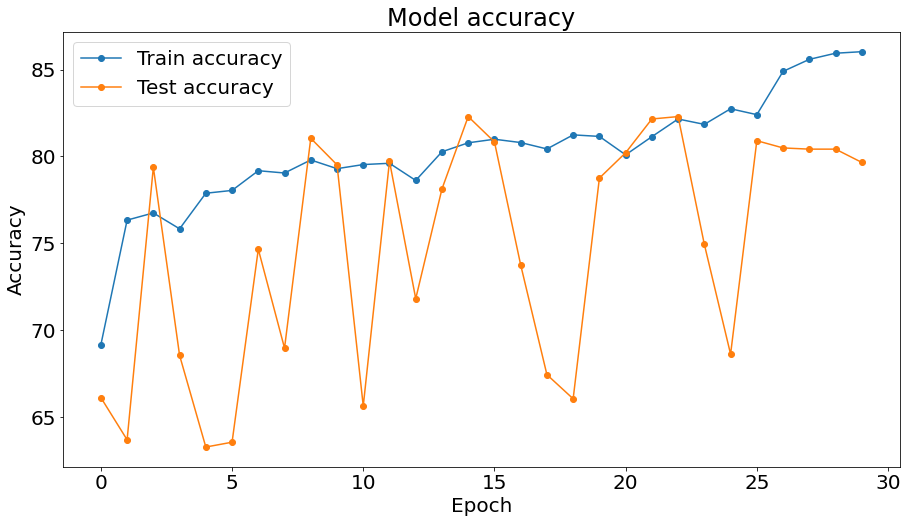

In [17]:
metric_plot(train_losses, test_losses, "loss")
metric_plot(train_accuracies, test_accuracies, "accuracy")